# Spurerkennung Schritt für Schritt

In [58]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from Calibration import Calibration


# alle Frames vom Video ( images/Udacity/project_video.mp4) laden mit opencv
cap = cv.VideoCapture("images/Udacity/project_video.mp4")

# print frame rate of video
fps = cap.get(cv.CAP_PROP_FPS)
print(f"Frames per second using video.get(cv.CAP_PROP_FPS) : {fps}")

# all frames of video as list of images and convert from BGR to RGB
original_frames = []
while True:
    ret, frame = cap.read()
    if ret:
        original_frames.append(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    else:
        break
cap.release()

#function to display video (from frames) in speed of 25 fps
def display_video(frames_to_display):
    for frame_to_display in frames_to_display:
        cv.imshow("frame", frame_to_display)
        if cv.waitKey(30) == 27:
            break
    cv.destroyAllWindows()

Frames per second using video.get(cv.CAP_PROP_FPS) : 25.0


In [59]:
# Helper function for getting coordinates
def setup_click_event(image):
    """
    Sets up a click event on an OpenCV window displaying the given image.
    Left click to display coordinates, right click to display BGR values.
    
    Args:
    image: Image read by cv.imread() or any other cv image object.
    """

    # Function to handle mouse click events
    def click_event(event, x, y, flags, param):
        # checking for left mouse clicks
        if event == cv.EVENT_LBUTTONDOWN:
            # displaying the coordinates on the image window
            font = cv.FONT_HERSHEY_SIMPLEX
            cv.putText(image, f'{x},{y}', (x, y), font, 1, (255, 0, 0), 2)
            cv.imshow('Image', image)

        # checking for right mouse clicks
        if event == cv.EVENT_RBUTTONDOWN:
            # displaying the BGR color values on the image window
            font = cv.FONT_HERSHEY_SIMPLEX
            b, g, r = image[y, x]
            cv.putText(image, f'{b},{g},{r}', (x, y), font, 1, (255, 255, 0), 2)
            cv.imshow('Image', image)

    # Display the image in a window
    cv.imshow('Image', image)

    # Setting the mouse callback function
    cv.setMouseCallback('Image', click_event)
                        
# Example of how to use the function
# setup_click_event(img)
# cv.waitKey(0)
# cv.destroyAllWindows()

## 0) Entzerrung

In [60]:
calib = Calibration()

# imgs = [cv.imread(f"images/Udacity/image00{i + 1}.jpg", cv.IMREAD_COLOR) for i in range(8)]
img = cv.imread("images/Udacity/image001.jpg", cv.IMREAD_COLOR)
# imgs = [cv.cvtColor(im, cv.COLOR_BGR2RGB) for im in imgs]
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# for all video frames
original_frames = [calib.undistort(frame) for frame in original_frames]
img = calib.undistort(img)

# display_video(original_frames)

## 1) Colormapping Gelb auf weiß

In [61]:
def yellow_to_white(img_to_change):
    img_hsv = cv.cvtColor(img_to_change, cv.COLOR_RGB2HSV)
    yellow_low = (19, 50 , 50)
    yellow_high = (70, 255, 255)
    img_to_change = img_to_change.copy()
    img_yellow = cv.inRange(img_hsv, yellow_low, yellow_high)
    img_to_change[np.where(img_yellow > 0)] = (255, 255, 255)
    return img_to_change

color_mapped_frames = [yellow_to_white(frame) for frame in original_frames]

# display_video(color_mapped_frames)

# color_mapped_frame = yellow_to_white(original_frames[1040])
# plt.figure(figsize=(20,10))
# plt.imshow(color_mapped_frame)

# setup_click_event(color_mapped_frame)
# cv.waitKey(0)
# cv.destroyAllWindows() # 503 / 447
# 
# # print("HSV color on 503 447 ")
# #color in HSV of original image
# print("RGB: ", original_frames[1040][434, 523])
# print(cv.cvtColor(original_frames[1040], cv.COLOR_RGB2HSV)[434, 523])


## 2) Grauwert

In [62]:
def grayscale(img):
    return cv.cvtColor(img, cv.COLOR_RGB2GRAY)

frames_grayscale = [grayscale(frame) for frame in color_mapped_frames]

# display_video(frames_grayscale)

## 3) Kantenerkennung mit Canny und Gaussian Blur

In [63]:
def canny(img, low_threshold, high_threshold):
    return cv.Canny(img.copy(), low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv.GaussianBlur(img.copy(), (kernel_size, kernel_size), cv.BORDER_DEFAULT)

low_treshold = 73
high_treshold = 143
kernel = 5

# # without gaussian blur:
# frames_canny = [canny(frame, low_treshold, high_treshold) for frame in frames_grayscale]
# display_video(frames_canny)
# #gaussian blur after:
# frames_canny = [gaussian_blur(frame, 3) for frame in frames_canny]
# display_video(frames_canny)

#gaussian blur before canny seems to be the best removing noise and not blurring the edges
frames_canny = [gaussian_blur(frame, kernel) for frame in frames_grayscale]
frames_canny = [canny(frame, low_treshold, high_treshold) for frame in frames_canny]
display_video(frames_canny)

## 4) Region of Interest mit Perspektivtransformation

In [64]:
# my region of interest:
# setup_click_event(frames_canny[0])
# cv.waitKey(0)
# cv.destroyAllWindows()
#Result: 

In [65]:
#display the roi in video as polygon
frames_roi = frames_canny.copy()
roi = np.array([[[565, 390], [683, 390], [1080, 596], [260, 596]]], dtype=np.int32)
# frames_roi = [(cv.polylines(frame, roi, True, (255, 0, 0), 2)) for frame in frames_roi]
# display_video(frames_roi)

In [66]:
# Region of no interest in the inside of the polygon

region_of_no_interest = np.array([[[575, 430], [633, 430], [980, 620], [390, 620]]], dtype=np.int32)
# frames_roi = [(cv.polylines(frame, region_of_no_interest, True, (255, 0, 0), 2)) for frame in frames_roi]
# display_video(frames_roi)

In [67]:
# Black out the region of no interest
frames_no_interest = [(cv.fillPoly(frame, region_of_no_interest, (0, 0, 0))) for frame in frames_roi]
# display_video(frames_roi)


In [68]:
# bblackout outside roi polygon
def black_outside_of_roi(img, roi):
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv.fillPoly(mask, roi, (255, 255, 255))
    return cv.bitwise_and(img, mask)

frames_roi = [black_outside_of_roi(frame, roi) for frame in frames_no_interest]
display_video(frames_roi)
    



## 5) Hough Transformation

In [69]:
def hough_lines(img_for_hough, rho, theta, threshold, min_line_len, max_line_gap):
    return cv.HoughLinesP(img_for_hough, rho=2, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=50, lines=np.array([]))

rho = 2
theta = np.pi/180
threshold = 100
min_line_len = 100
max_line_gap = 50


lines=[hough_lines(frame, rho, theta, threshold, min_line_len, max_line_gap) for frame in frames_roi]

#draw lines on og images
# drawn_lines =[]
# for i, frame in enumerate(original_frames):
#     frame_drawn = frame.copy()
#     for line in lines[i]:
#         for x1,y1,x2,y2 in line:
#             cv.line(frame_drawn,(x1,y1),(x2,y2),(255,0,0),2)
#     drawn_lines.append(frame_drawn)
    

In [70]:
# display_video(drawn_lines)

## 6) Polynomfit

In [71]:
# One Polynom for left lane (left half of image) and one for right lane (right half of image)

def get_left_right_lane_lines(lines, img_shape):
    left_lane_lines = []
    right_lane_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 < img_shape[1]/2 and x2 < img_shape[1]/2:
                left_lane_lines.append(line)
            elif x1 > img_shape[1]/2 and x2 > img_shape[1]/2:
                right_lane_lines.append(line)
                
    return left_lane_lines, right_lane_lines

def get_x_y_from_lines(lines):
    #gets all points and not only the endpoints of the lines
    x_list = []
    y_list = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            x_list.append(x1)
            x_list.append(x2)
            y_list.append(y1)
            y_list.append(y2)
            
            # loop from y1 to y2 and get x for every y
            for y in range(y1, y2):
                y_list.append(y)
                x_list.append((y-y1)/(y2-y1)*(x2-x1)+x1)
    return x_list, y_list

def get_polynom(x, y):
    return np.polyfit(x, y, 2)

# display polynom on image
def display_polynom(img_to_display_polynom, polynom, color):  
    # go over all x values and draw a circle on the image
    for x in range(0, img_to_display_polynom.shape[1]):
        y = int(polynom[0]*x**2 + polynom[1]*x + polynom[2])
        if y in range(400, 600):
            cv.circle(img_to_display_polynom, (x, y), 1, color, 2)

    return img_to_display_polynom
        







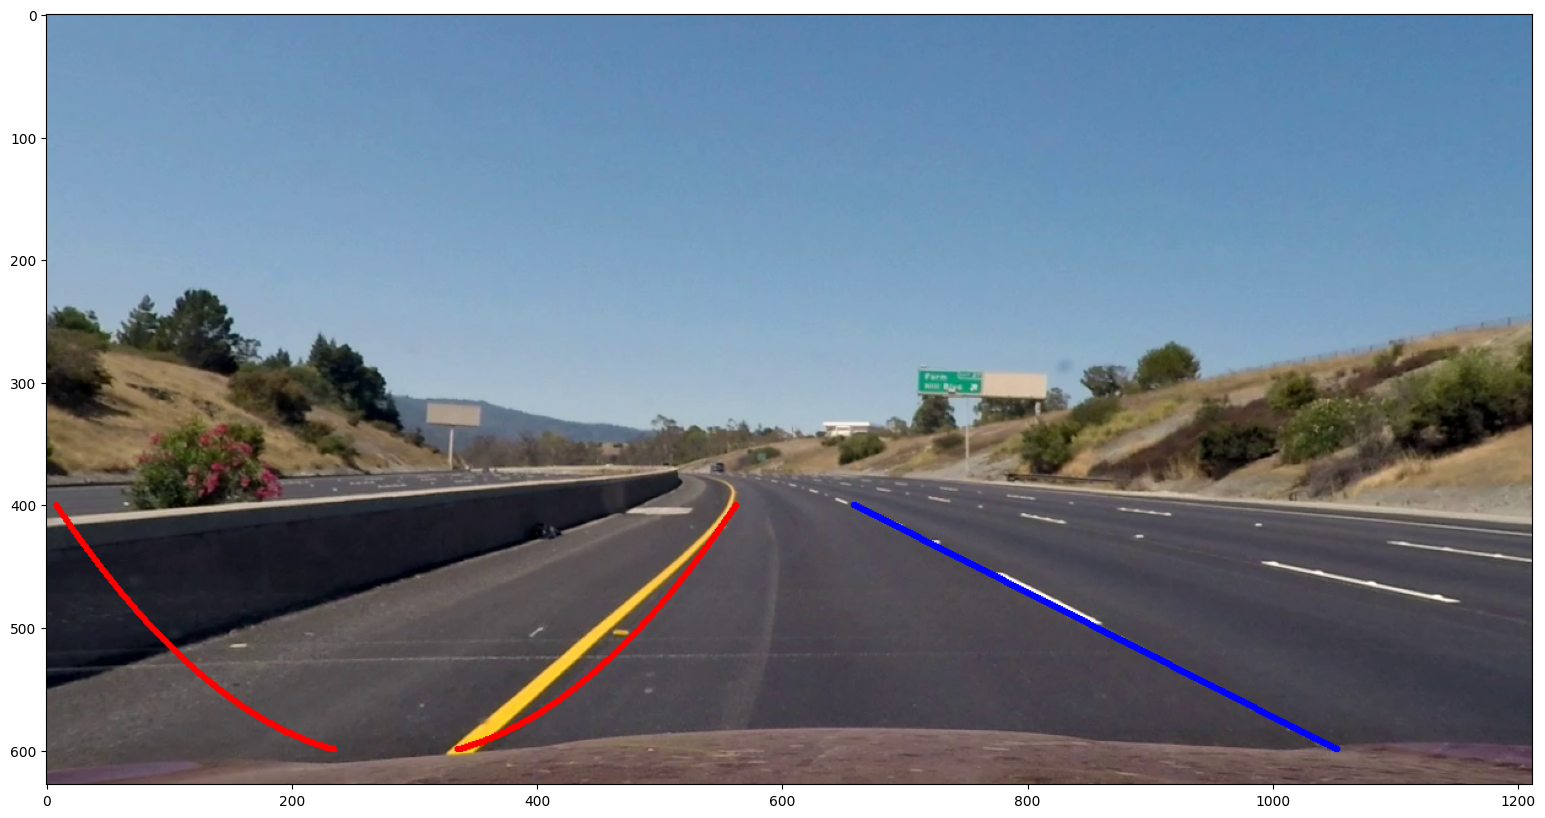

In [72]:
# get left and right lane lines
left_lane_lines, right_lane_lines = get_left_right_lane_lines(lines[0], original_frames[0].shape)
# get x and y from lines
x_left, y_left = get_x_y_from_lines(left_lane_lines)
x_right, y_right = get_x_y_from_lines(right_lane_lines)
# get polynom
polynom_left = get_polynom(x_left, y_left)
polynom_right = get_polynom(x_right, y_right)

# display polynom on image
polynom_left_img = display_polynom(original_frames[0].copy(), polynom_left, (255, 0, 0))
polynom_right_img = display_polynom(polynom_left_img.copy(), polynom_right, (0, 0, 255))
plt.figure(figsize=(20,10))
plt.imshow(polynom_right_img)


In [73]:
# now as function for all frames
def get_and_draw_polynom(lanes, polynom_img):
    try:
        left_lane_lines, right_lane_lines = get_left_right_lane_lines(lanes, polynom_img.shape)
        x_left, y_left = get_x_y_from_lines(left_lane_lines)
        x_right, y_right = get_x_y_from_lines(right_lane_lines)
        polynom_left = get_polynom(x_left, y_left)
        polynom_img = display_polynom(polynom_img.copy(), polynom_left, (255, 0, 0))
        
    except Exception as e:
        print(e)
        print("left no lines found")
    try:
        polynom_right = get_polynom(x_right, y_right)
        polynom_img = display_polynom(polynom_img.copy(), polynom_right, (0, 0, 255))
    except Exception as e:
        print(e)
        print("left no lines found")
        
    return polynom_img

polynom_frames = [get_and_draw_polynom(frame, original_frames[i].copy()) for i, frame in enumerate(lines)]
display_video(polynom_frames)



expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non

C:\Users\bensc\AppData\Local\Temp\ipykernel_18456\3220051642.py:33: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, 2)


expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non-empty vector for x
left no lines found
expected non

## Alternative) Direkt auf Grayscale Gauss -> Tresholding -> Polynomfitting

In [78]:
# grayscale
# gaussian blur
# tresholding
# polynomfitting
# display polynom on image
# display_video(frames_grayscale)

frames_blurred = [gaussian_blur(frame, kernel) for frame in frames_grayscale]
frames_tresholded = [cv.threshold(frame, 190, 255, cv.THRESH_BINARY)[1] for frame in frames_blurred]
# display_video(frames_tresholded)
#roi and no interest
frames_roi = [black_outside_of_roi(frame, roi) for frame in frames_tresholded]
frames_no_interest = [(cv.fillPoly(frame, region_of_no_interest, (0, 0, 0))) for frame in frames_roi]
display_video(frames_no_interest)

In [80]:
# polynomfitting on the tresholded image directly
def get_and_draw_polynom_from_image(image_to_fit_the_polynom, image_to_draw_on):
    # use all points of left side of image and fit polynom for left lane
    x_left = []
    y_left = []
    for x in range(0, image_to_fit_the_polynom.shape[1]//2):
        for y in range(0, image_to_fit_the_polynom.shape[0]):
            if image_to_fit_the_polynom[y, x] == 255:
                x_left.append(x)
                y_left.append(y)
    polynom_left = get_polynom(x_left, y_left)
    image_to_draw_on = display_polynom(image_to_draw_on.copy(), polynom_left, (255, 0, 0))
    
    # use all points of right side of image and fit polynom for right lane
    x_right = []
    y_right = []
    for x in range(image_to_fit_the_polynom.shape[1]//2, image_to_fit_the_polynom.shape[1]):
        for y in range(0, image_to_fit_the_polynom.shape[0]):
            if image_to_fit_the_polynom[y, x] == 255:
                x_right.append(x)
                y_right.append(y)
    polynom_right = get_polynom(x_right, y_right)
    image_to_draw_on = display_polynom(image_to_draw_on.copy(), polynom_right, (0, 0, 255))
    return image_to_draw_on

polynom_frames = [get_and_draw_polynom_from_image(frame, original_frames[i].copy()) for i, frame in enumerate(frames_no_interest)]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\bensc\Projects\digitale_bildverarbeitung_projekt\conventional_lane_detection\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bensc\AppData\Local\Temp\ipykernel_18456\463673163.py", line 26, in <module>
    polynom_frames = [get_and_draw_polynom_from_image(frame, original_frames[i].copy()) for i, frame in enumerate(frames_no_interest)]
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bensc\AppData\Local\Temp\ipykernel_18456\463673163.py", line 26, in <listcomp>
    polynom_frames = [get_and_draw_polynom_from_image(frame, original_frames[i].copy()) for i, frame in enumerate(frames_no_interest)]
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bensc\AppData\Local\Temp\ipykernel_1

In [ ]:
display_video(polynom_frames)